In [2]:

import matplotlib.pyplot as plt
#%matplotlib inline

import sys
import os

import scipy.sparse.linalg as spsl

import numpy as np


In [11]:
h1=5
w1=1

def force(x):
    return -h1*4*(x**2-w1)*x;
def energy(x):
    return h1*(x**2-w1)**2

nrSteps = 1000

x = np.ones(nrSteps)
p = np.random.randn(nrSteps)
dt=0.01
gamma = 1
kT = 1
a = np.exp(-gamma * (dt))
b = np.sqrt(1 - np.exp(-2 * gamma * (dt)))


pn = p[0]
xn = x[0]
    
f=force(xn)

for n in range(nrSteps-1):
        
        
        
        pn = pn + 0.5* f * dt
        xn = xn + 0.5* pn * dt
        pn = (a * pn) + b * np.random.randn(*xn.shape) * np.sqrt(kT)
        f=force(xn)
        xn = xn + 0.5* pn * dt
        pn = pn + 0.5* f * dt
        
        p[n+1] = pn
        x[n+1] = xn
    


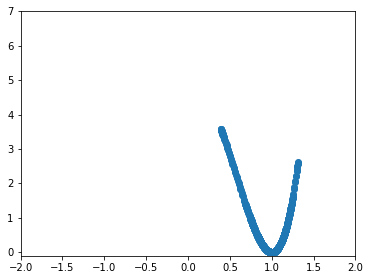

In [160]:
def plotSampling_fromData(x, methodName=None, color='b', title = 'Initial condition', savefigure=None):
    
    fig = plt.figure(figsize=(6,4.5))
    ax = fig.add_subplot(111)
    ax.scatter(x, energy(x))
    ax.set_xlim([-2,2])
    ax.set_ylim([-0.1,7])
    if savefigure is not None:
        plt.savefig(savefigure,  format='png', dpi=100, bbox_inches='tight')
        
    plt.show()
        
   
    
plotSampling_fromData(x, methodName=None, color='b', title = 'Initial condition', savefigure=None)

#  Stein force

In [161]:
from sklearn.neighbors import NearestNeighbors
from scipy.spatial.distance import cdist

def compute_force(XL, leader_set):
       
    f = []
    
    for n in range(len(leader_set)):
        f.append( force(XL[leader_set[n]]))

    return f

def compute_force_all(XL):
       
    f = []
    
    for n in range(len(XL)):
        f.append( force(XL[n]))

    return f

def compute_stein_force(XL, leader_set):
   
    force = compute_force(XL, leader_set)
    # create numpy array from the list force which has also units    
    forcenp = []
    # remove units (we needed the units for the force call before!)
    for n in range(len(leader_set)):
        forcenp.append(force[n])
    
    forcenp = np.asarray(forcenp)
    # create numpy array from the list XL which has also units
    
    #XreshList = []
    ## remove units (we needed the units for the force call before!)
    #for n in range(len(XL)):
    #    XreshList.append(XL[n])
    
    Xresh = np.asarray(XL)
    #print(Xresh.shape)
    # reshape for neighbor search steps x DOF
    Xresh = Xresh.reshape(Xresh.shape[0],Xresh.shape[1]*Xresh.shape[2])
    # choose leader particles using the index set leader_set
    X_leader = np.copy(Xresh[leader_set,:])
    
    force_resh = forcenp.reshape(forcenp.shape[0])
   
    # kernel scaling parameter
    h=0.04
    
    distances = cdist(X_leader, Xresh)
    kernel = np.exp(-distances**2 / h)
    
    # this computes the first part (without the kernel derivatives)
    # f_MDforce is of the format (N_particles, dim)
    f_MDforce = np.dot(kernel.transpose(), force_resh)
    f_MDforce = f_MDforce / len(leader_set)
    # reshape to format (N_particles, n_atoms, 3)
    f_MDforce = f_MDforce.reshape(Xresh.shape[0], forcenp.shape[1], forcenp.shape[2])
    # add force unit and divide by kT
    #f_MDforce = f_MDforce * model.force_unit / smpl.kT
    f_MDforce = f_MDforce  / kT
    
    #derivative part
    f_der = -2.0/h * np.dot(kernel.transpose(), X_leader)
    f_der += 2.0/h * np.outer(np.sum(kernel,0),np.ones(Xresh.shape[1])) * Xresh
    f_der = f_der / len(leader_set)
    # reshape to format (N_particles, n_atoms, 3)
    f_der = f_der.reshape(Xresh.shape[0], forcenp.shape[1], forcenp.shape[2])
    # add unit
    #f_der = f_der * model.x_unit**(-1)
    
    return f_MDforce + f_der



# Iterate Stein

1


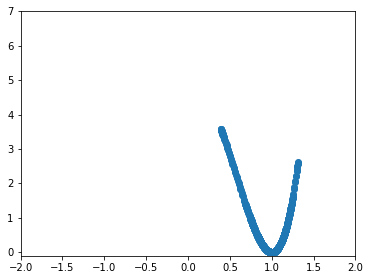

Stein iteration 0


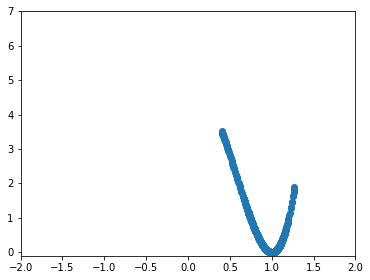

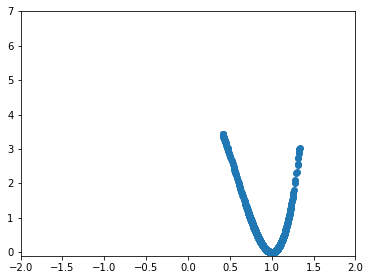

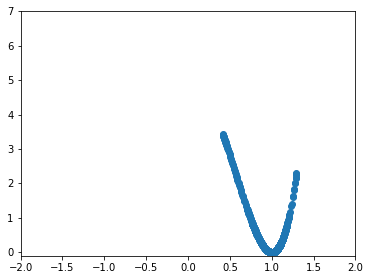

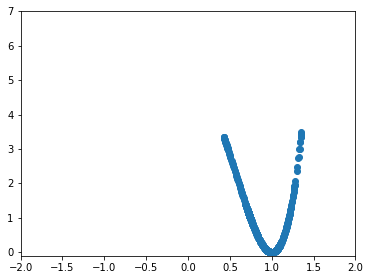

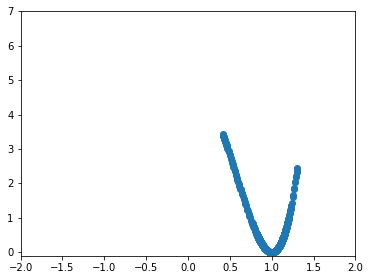

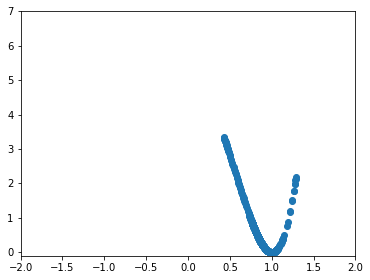

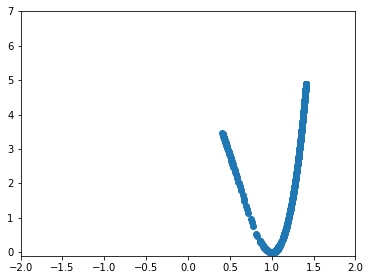

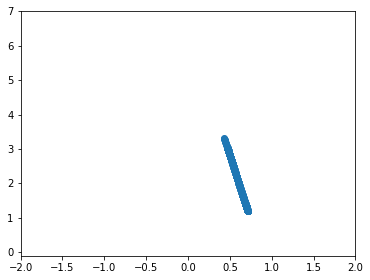

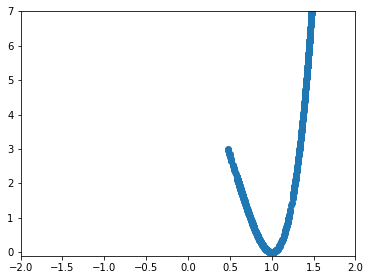

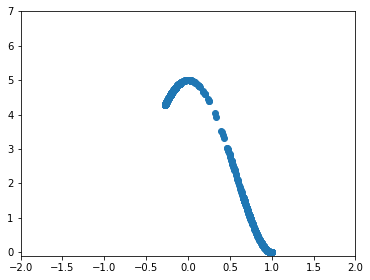

Stein iteration 10


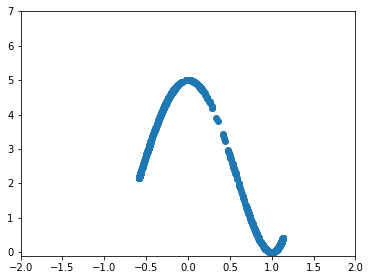

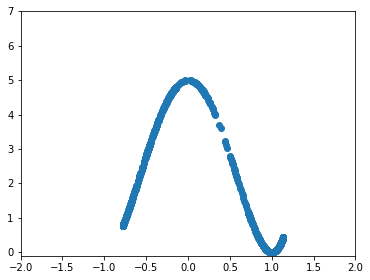

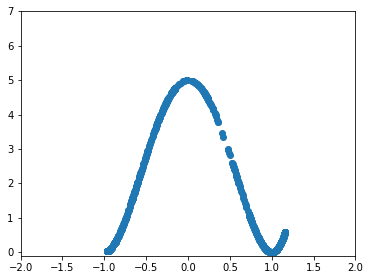

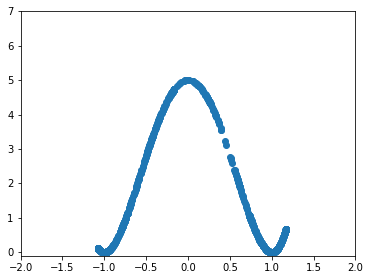

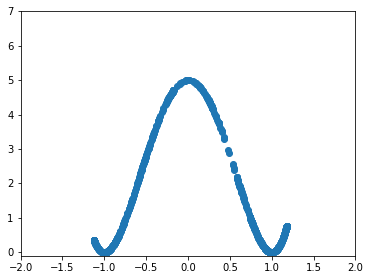

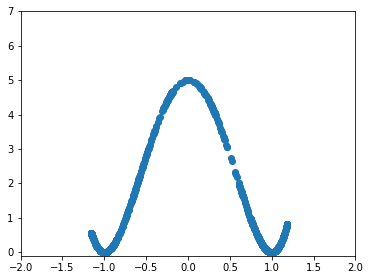

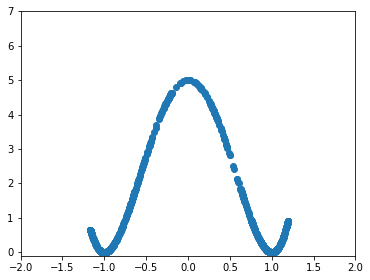

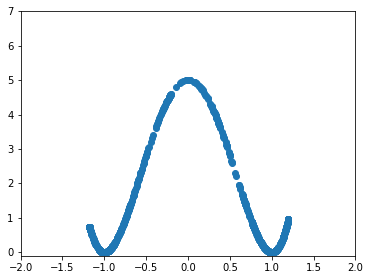

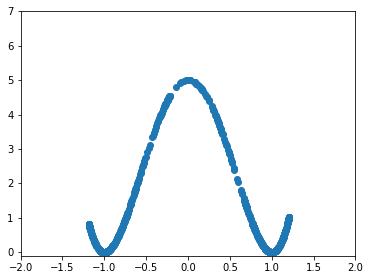

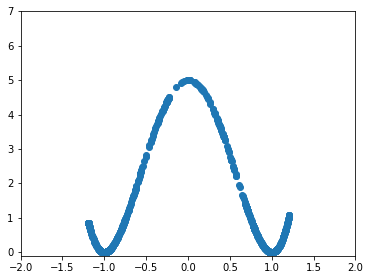

Stein iteration 20


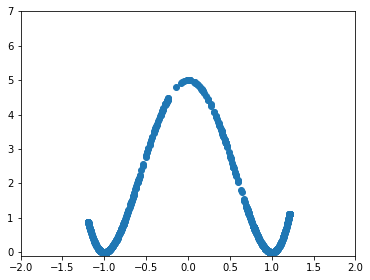

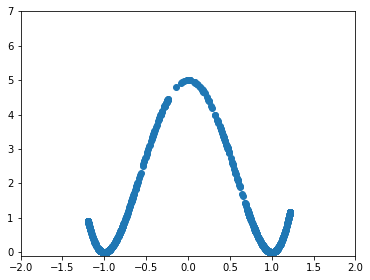

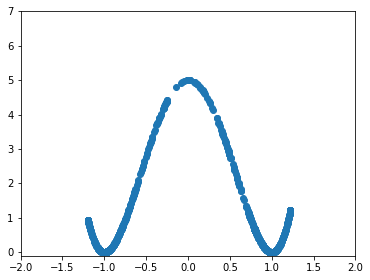

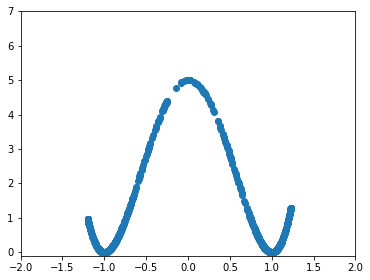

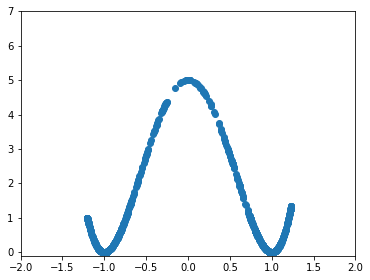

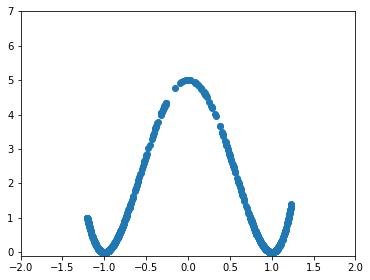

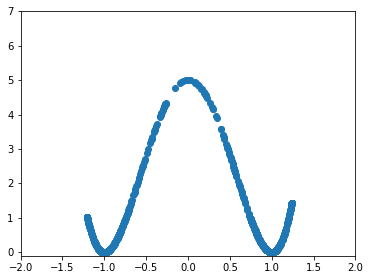

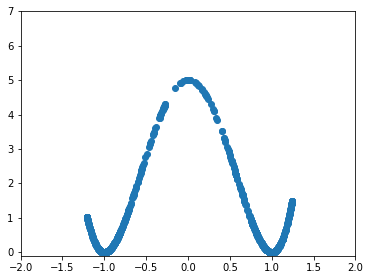

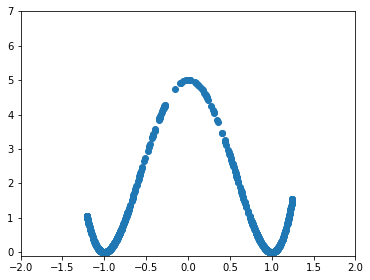

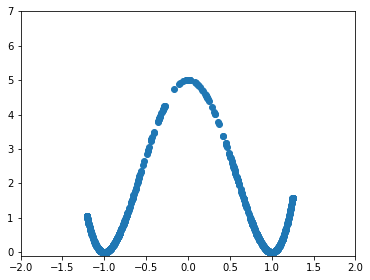

Stein iteration 30


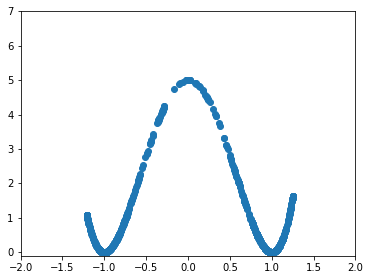

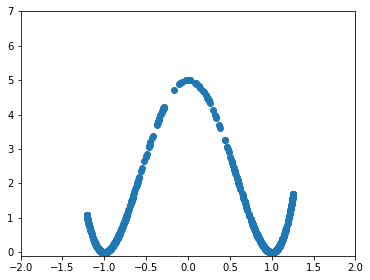

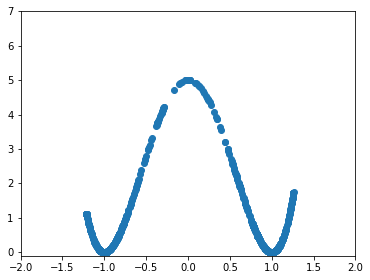

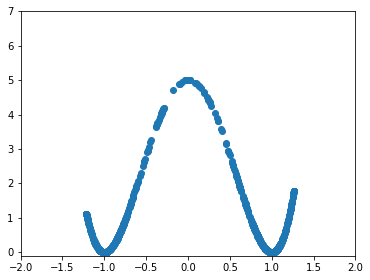

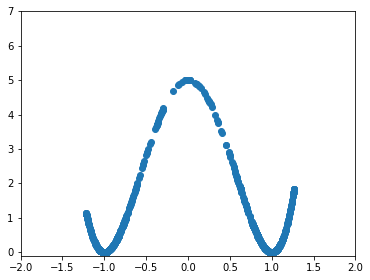

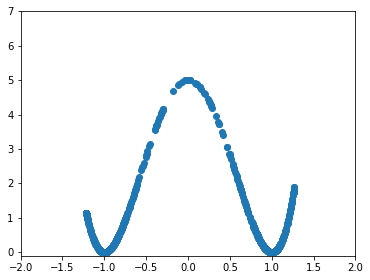

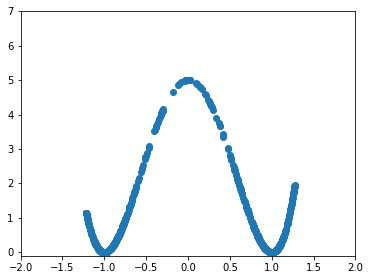

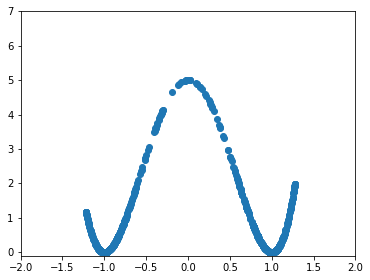

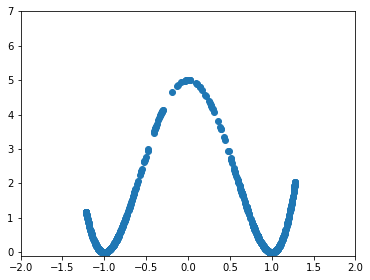

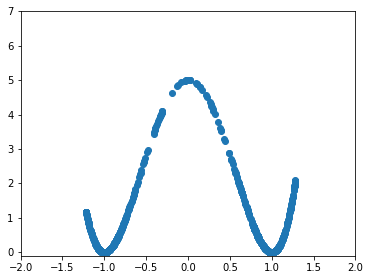

Stein iteration 40


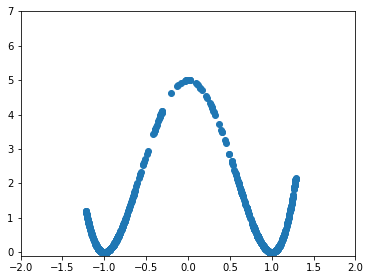

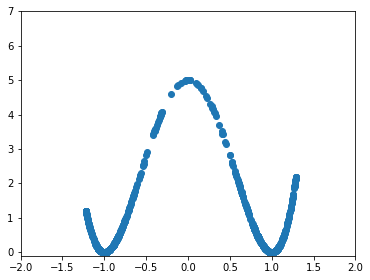

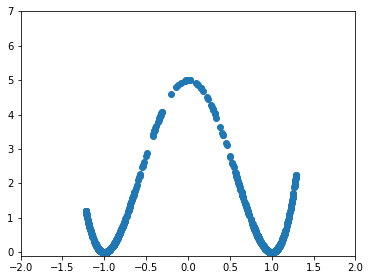

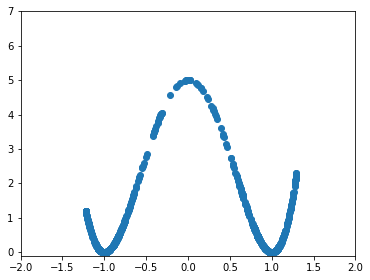

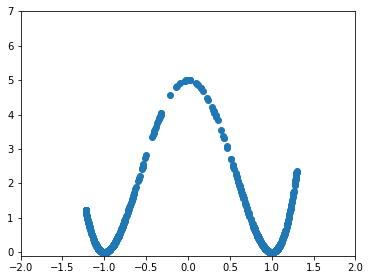

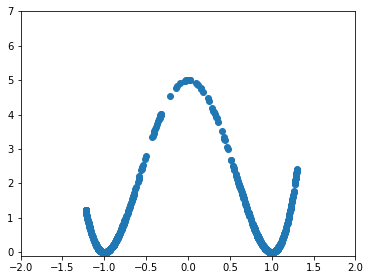

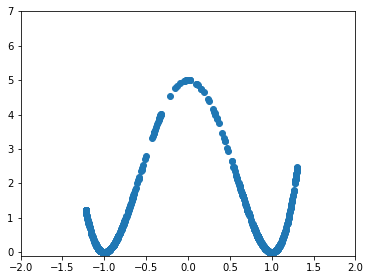

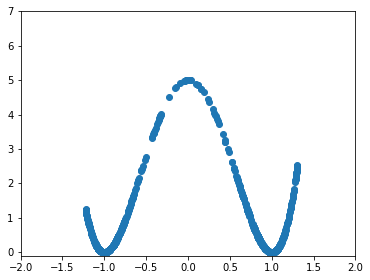

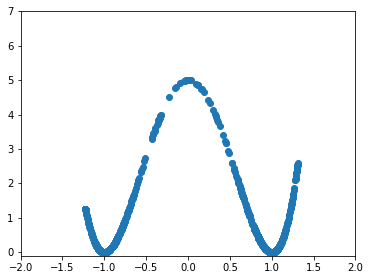

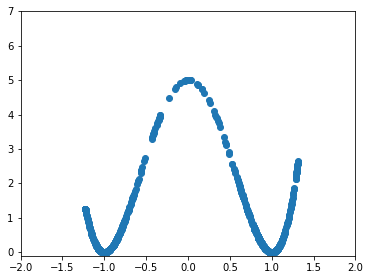

Stein iteration 50


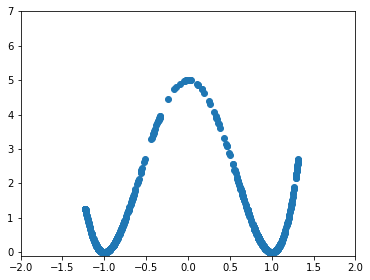

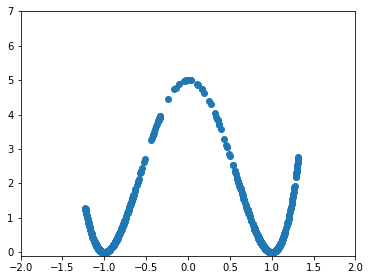

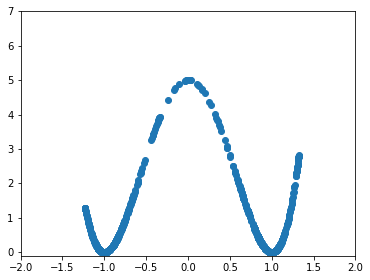

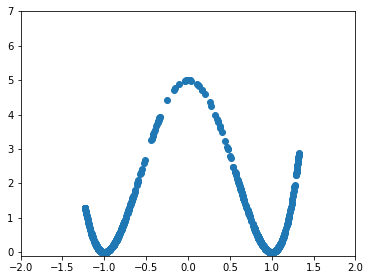

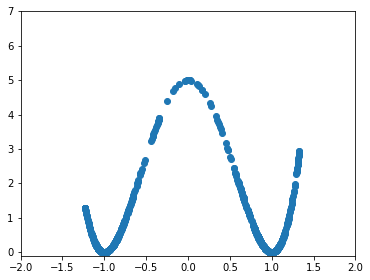

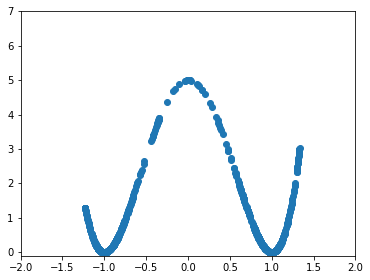

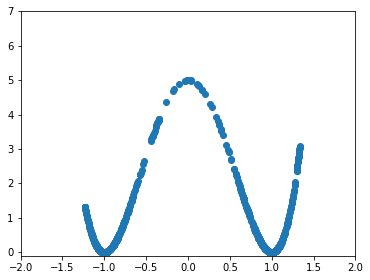

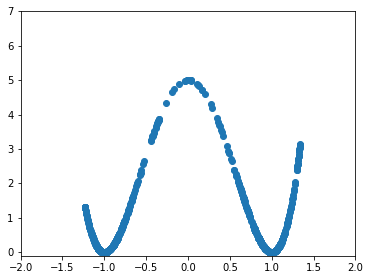

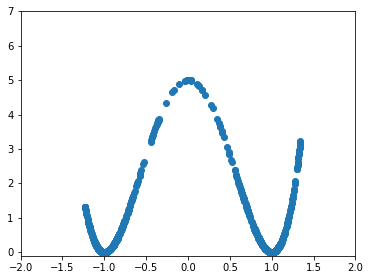

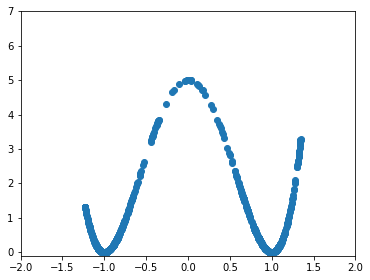

Stein iteration 60


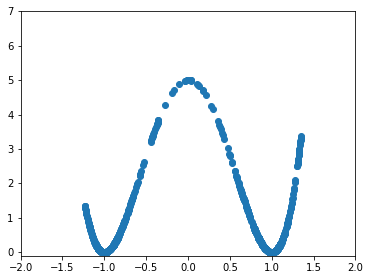

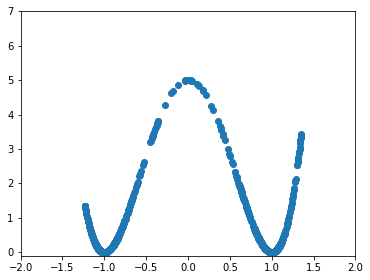

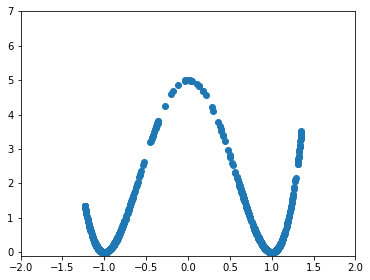

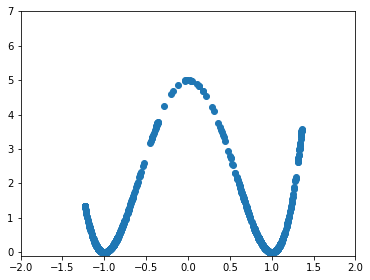

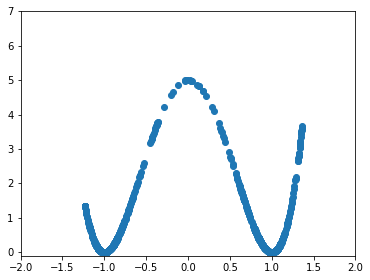

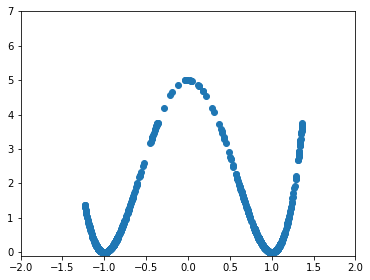

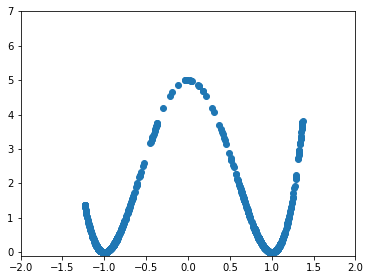

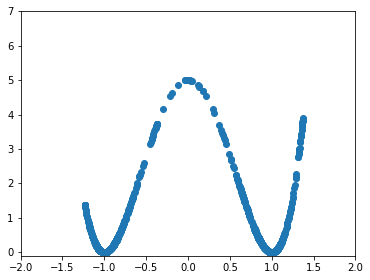

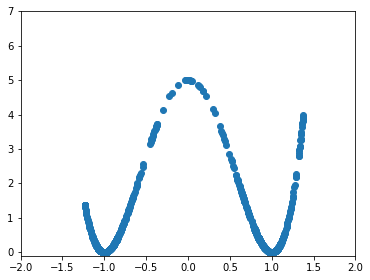

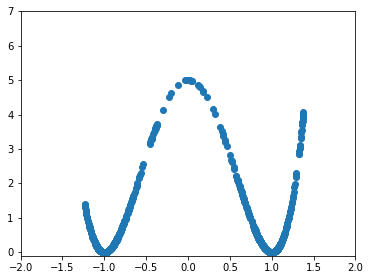

Stein iteration 70


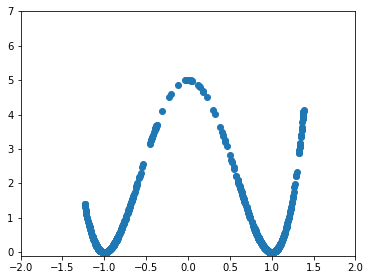

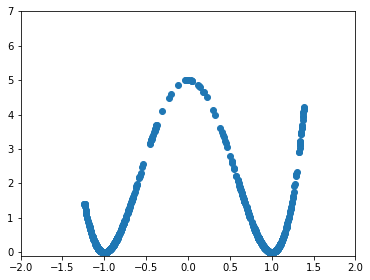

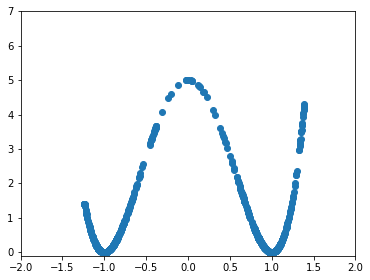

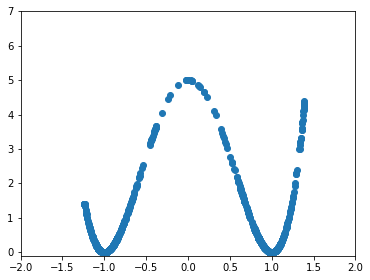

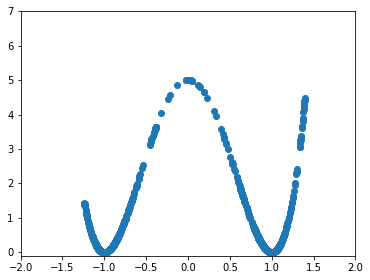

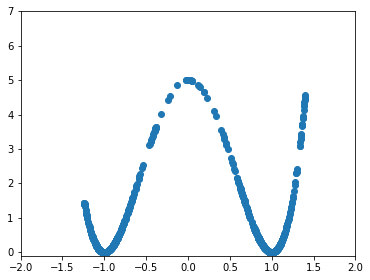

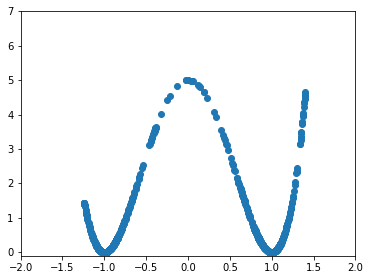

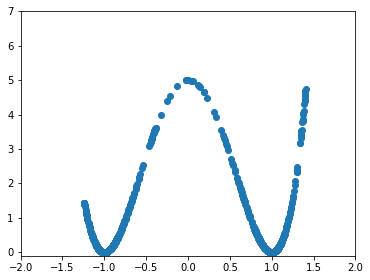

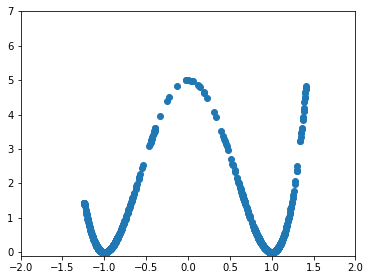

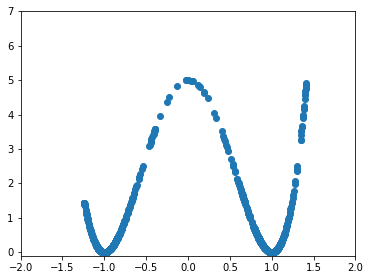

Stein iteration 80


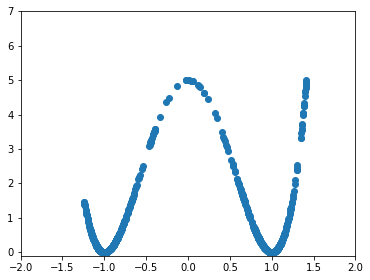

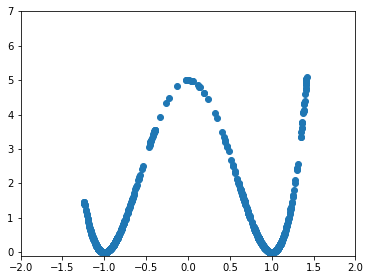

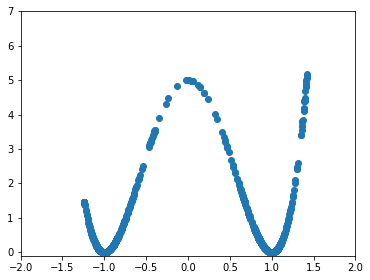

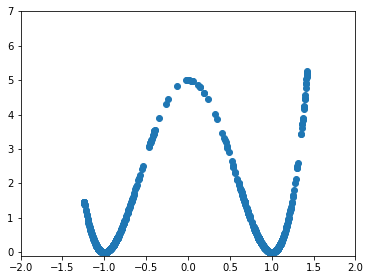

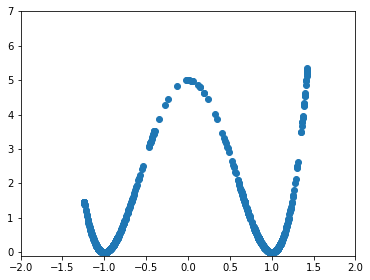

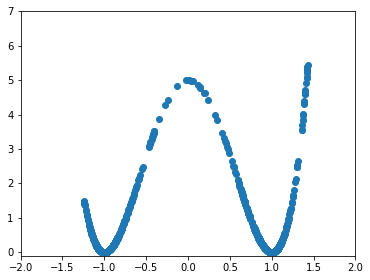

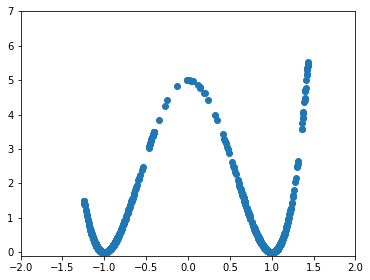

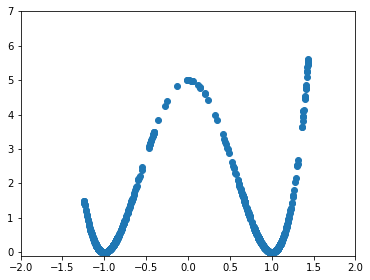

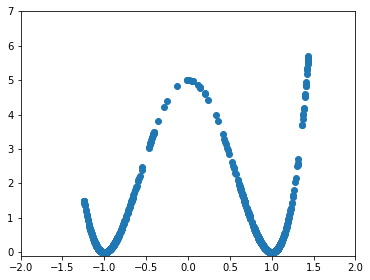

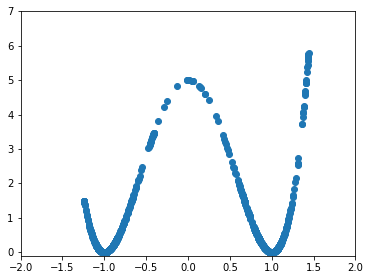

Stein iteration 90


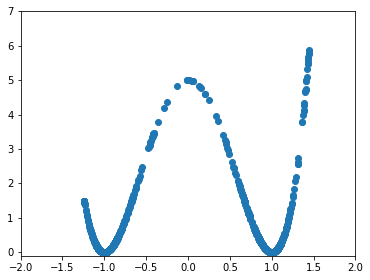

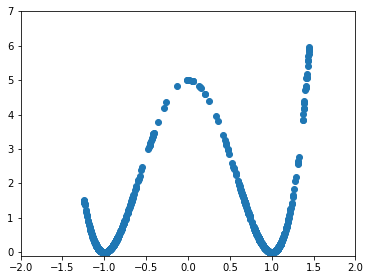

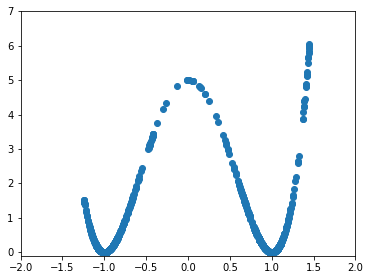

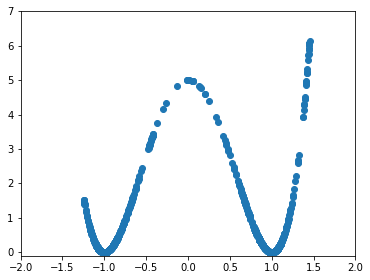

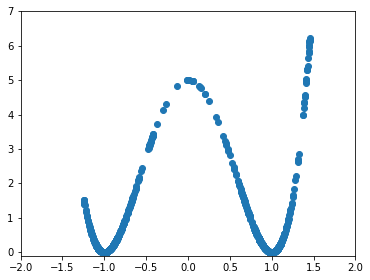

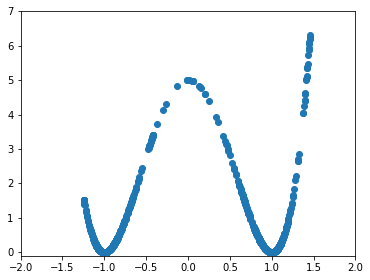

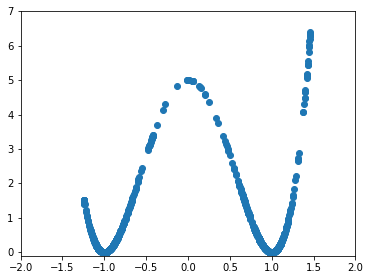

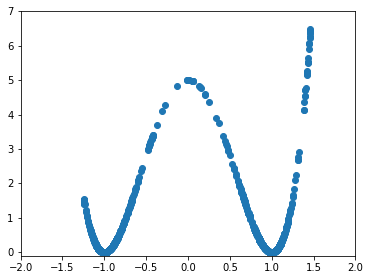

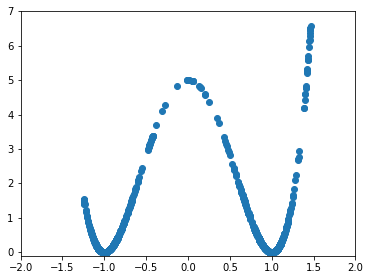

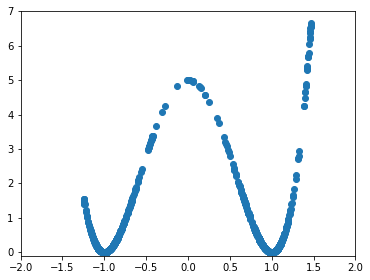

In [162]:
numberOfSteinSteps = 100#50000

X_short = np.copy(x)

epsilon_step=0.1

# choose leader set
numberOfLeaderParticles = int(0.2*(X_short.shape[0]))
leader_set = np.random.choice(range(X_short.shape[0]), numberOfLeaderParticles)#np.array(range(X_short.shape[0]))# 

mass = 1 

q = np.zeros((len(X_short), 1, 1))
q[:,0,0] = np.copy(X_short)
print(q.shape[2])

XL=np.copy(q)
plotSampling_fromData(q, methodName=None, color='b', title = 'Initial condition')
f = compute_stein_force(XL,leader_set)
#f = compute_force(XL)

modit = int(numberOfSteinSteps/10)
moditfig = 1#int(numberOfSteinSteps/100)

for ns in range(numberOfSteinSteps):
    if ns%modit==0:
        print('Stein iteration '+repr(ns))
    f = compute_stein_force(XL,leader_set)
    for n in range(len(XL)):
        XL[n] = (XL[n] + epsilon_step * f[n])#/mass );
        q[n,:,:] =  np.copy(XL[n])
    
    ## plot progress
    if ns%moditfig==0:
        plotSampling_fromData(q, methodName=None, color='b', title = 'Initial condition', savefigure='SteinFigures/it_'+repr(ns)+'.png')
    if np.isnan(q).any():
        print('Explosion. Nan.')
        break
    

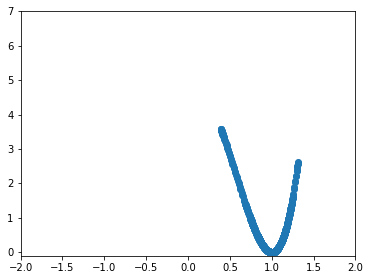

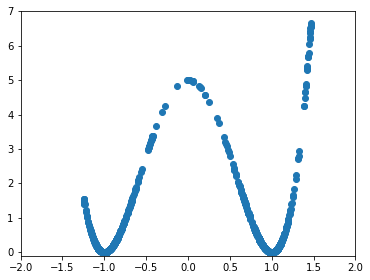

In [163]:
plotSampling_fromData(x,  methodName=None, color='b', title='Initial state')
plotSampling_fromData(q, methodName=None, color='b', title = 'After '+repr(numberOfSteinSteps)+' Stein steps')


In [206]:
from scipy.integrate import quadrature
def fit_distribution(x):
    x = x[:,0,0]
    Z = 0.5725340617#quadrature(lambda y : np.exp(-energy(y)), -1000, 1000)[1]
    xx = np.linspace(-2,2,100)
    
    fig = plt.figure(figsize=(6,4.5))
    ax = fig.add_subplot(111)
    ax.hist(x, 50, density=True);
    ax.scatter(xx, np.exp(- energy(xx))/Z , c='r', s=5)
   
    plt.show()

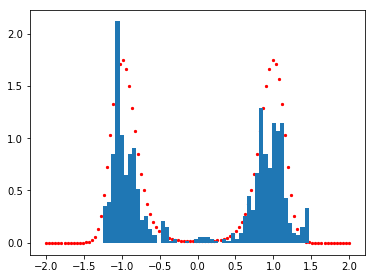

In [207]:
fit_distribution(q)


In [210]:
Z = 0.5725340617
print('Z='+repr(Z))

print('E[x] = 0')
print(np.mean(X_short))
print(np.mean(q))
print('************')

print('E[V(x)] = 0.5247724179')
print(np.mean(energy(X_short)))
print(np.mean(energy(q)))

print('E[-f(x)*x] = 1')
print(np.mean((-force(X_short)* X_short)))
print((np.mean(-force(q)* q)))

Z=0.5725340617
E[x] = 0
0.958395770125
0.0440037472944
E[V(x)] = 0.5247724179
0.56629019526
0.717541516704
E[-f(x)*x] = 1
1.34001874819
1.60830663395


In [168]:
import glob
import moviepy.editor as mpy

gif_name = 'SteinFigures/stein'
fps = 1000
file_list = glob.glob('SteinFigures/'+'/*.png') # Get all the pngs in the current directory
list.sort(file_list, key=lambda x: int(x.split('_')[1].split('.png')[0])) # Sort the images by #, this may need to be tweaked for your use case
clip = mpy.ImageSequenceClip(file_list, fps=fps)
clip.write_gif('{}.gif'.format(gif_name), fps=fps)


[MoviePy] Building file SteinFigures/stein.gif with imageio


100%|██████████| 101/101 [00:01<00:00, 84.79it/s]
